In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
# additional imports

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# OVERVIEW OF DATA

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


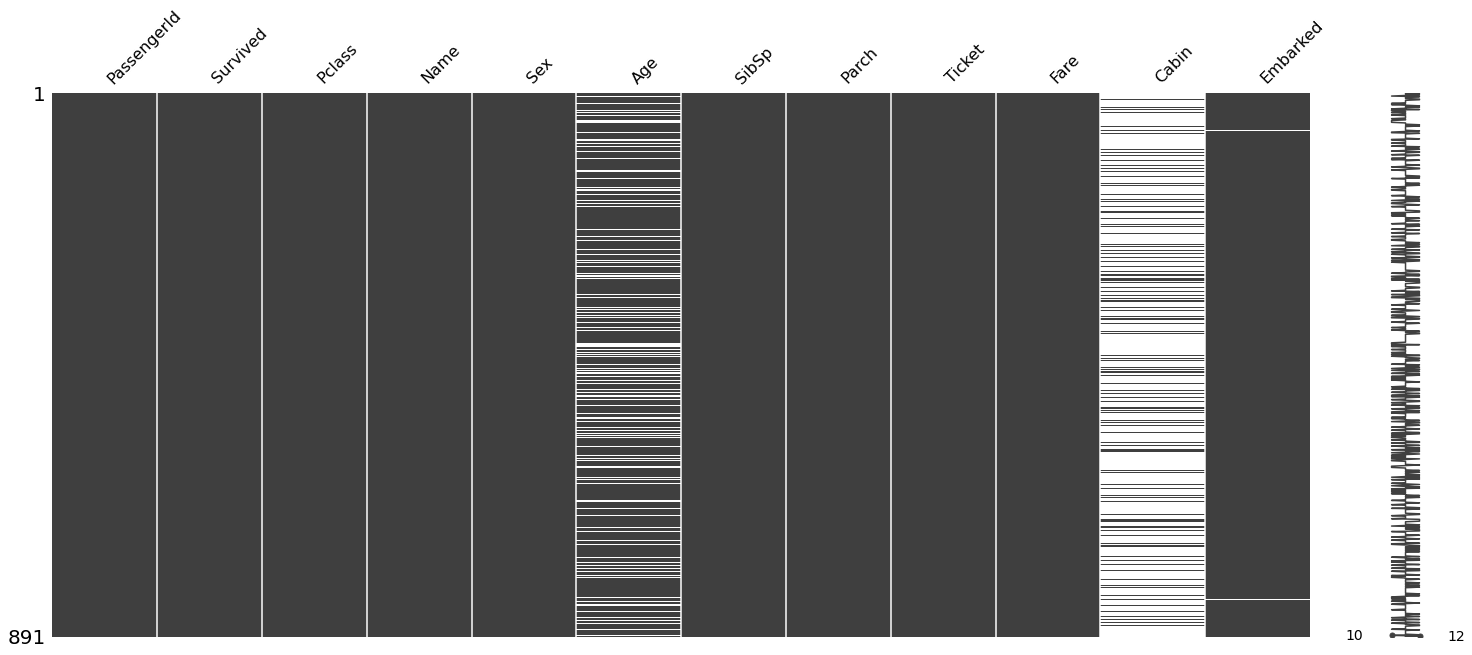

In [5]:
# Only 'Age', 'Cabin', 'Embarked' have missing values out of all the potential features
missingno.matrix(train, figsize = (25,10))

In [6]:
# we see that 'Embarked' is only missing two values so we delete those two rows from the data set
train.dropna(subset=['Embarked'],inplace=True)

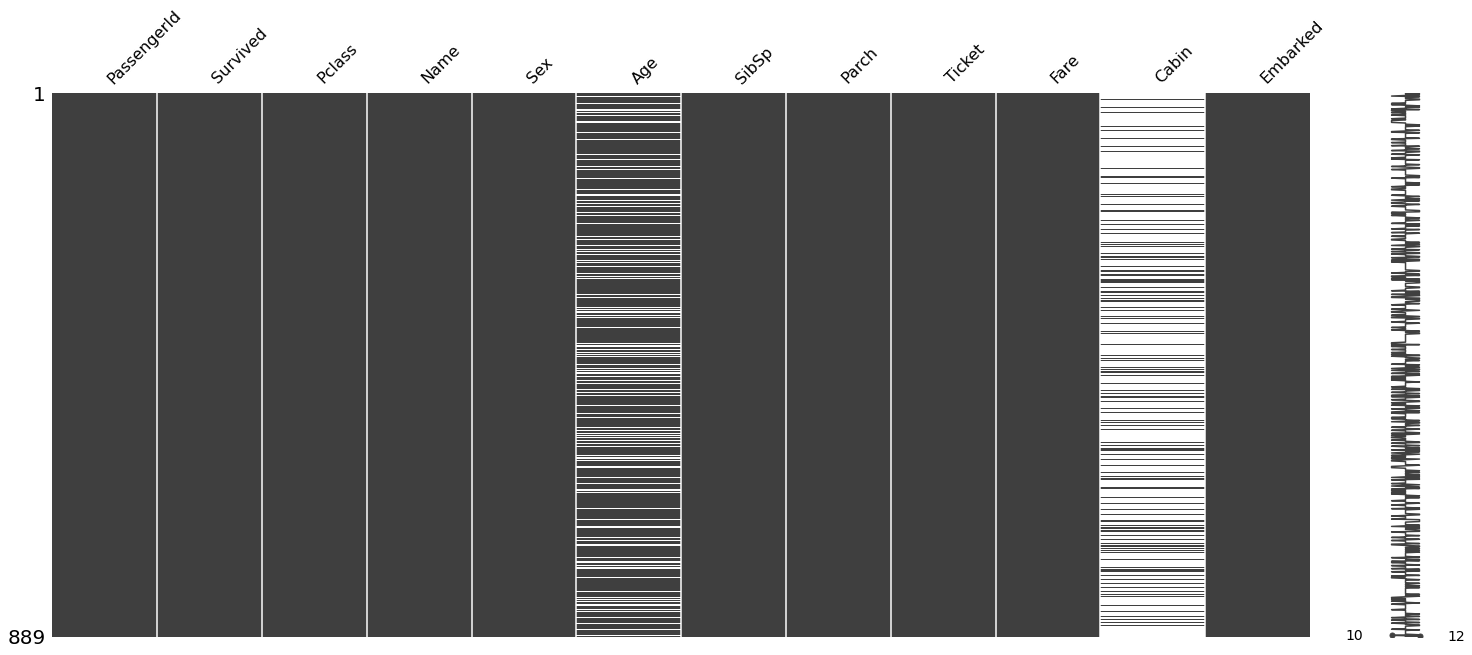

In [7]:
missingno.matrix(train, figsize = (25,10))

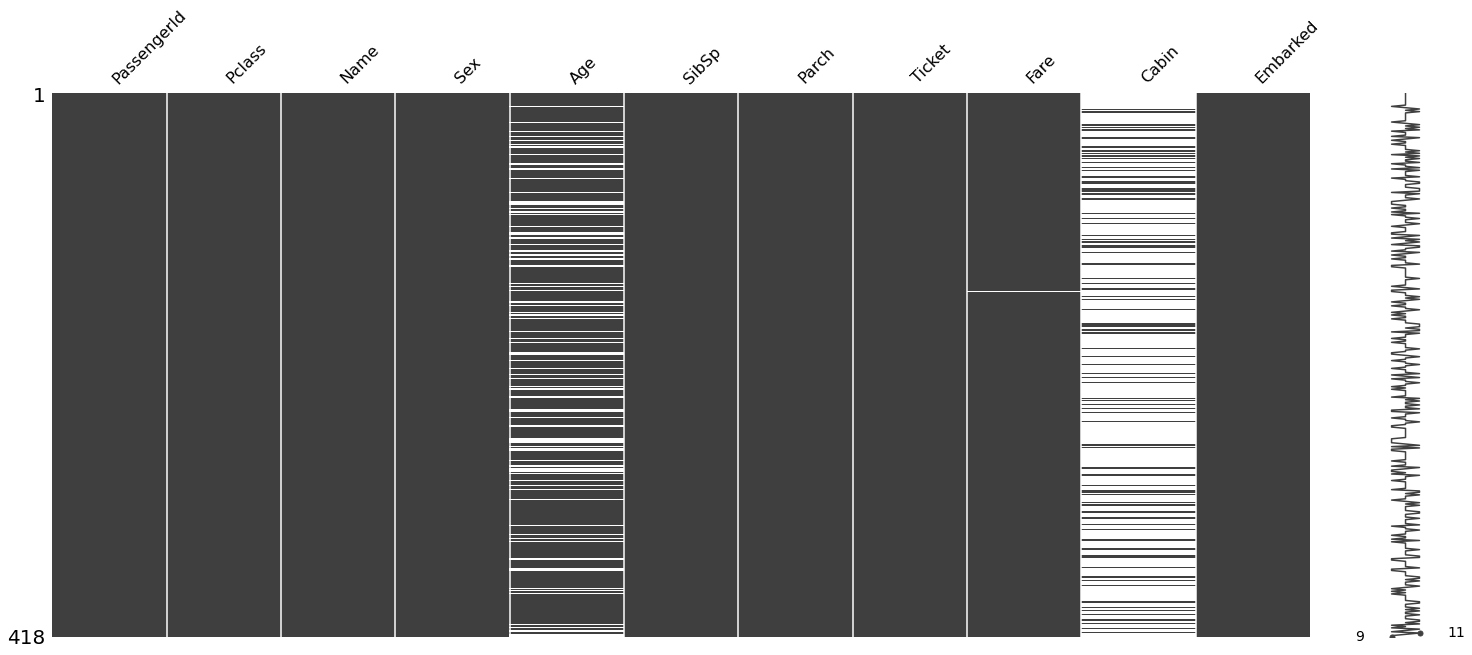

In [8]:
# the test data is also missing values
missingno.matrix(test, figsize = (25,10))

# ANALYSIS OF POTENTIAL FEATURE

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(train.drop(['Survived'],axis=1), train['Survived'], train_size=0.8, test_size=0.2,
                                                                random_state=0)

X_train = pd.DataFrame()
categorical_data_train = pd.DataFrame()
X_valid = pd.DataFrame()
categorical_data_valid = pd.DataFrame()

X_test = pd.DataFrame()
categorical_data_test = pd.DataFrame()

### PassengerId

In [10]:
# PassengerId  = index + 1
# it doesn't add any useful information the model can use
# therefore we won't use it as a feature
x_train['PassengerId'].head()
x_train['PassengerId'].tail()

837    838
193    194
630    631
560    561
685    686
Name: PassengerId, dtype: int64

## Pclass

In [11]:
x_train['Pclass'].value_counts()

3    395
1    167
2    149
Name: Pclass, dtype: int64

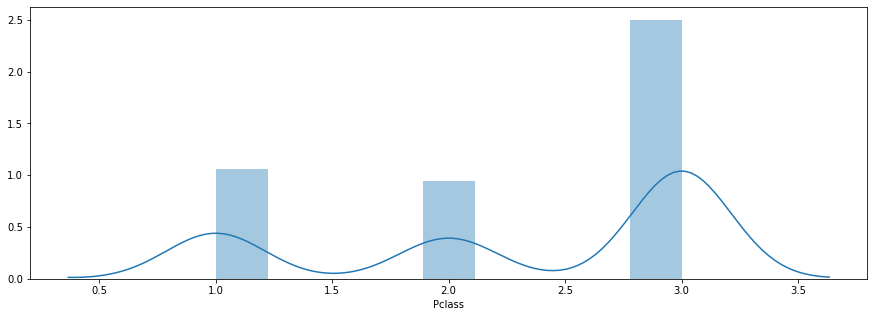

In [12]:
plt.figure(figsize = (15,5))
sns.distplot(a=x_train['Pclass'])

In [13]:
# The values are categorical ordinal values (even though they're numbers)
# We will use Pclass as a feature
# Since the values are already numbers we can directly add it to x
X_train['Pclass']=x_train['Pclass']
X_valid['Pclass']=x_valid['Pclass']
X_test['Pclass']=test["Pclass"]

## Name

In [14]:
x_train['Name'].nunique() # 712 out of 712 unique values
x_train['Name'].head(10)

364                          O'Brien, Mr. Thomas
256               Thorne, Mrs. Gertrude Maybelle
477                    Braund, Mr. Lewis Richard
272    Mellinger, Mrs. (Elizabeth Anne Maidment)
554                           Ohman, Miss. Velin
768                          Moran, Mr. Daniel J
232                    Sjostedt, Mr. Ernst Adolf
536            Butt, Major. Archibald Willingham
163                              Calic, Mr. Jovo
659                   Newell, Mr. Arthur Webster
Name: Name, dtype: object

In [15]:
# Every name is different so the raw data of 'Name' won't add any useful information
# However, by examining the data we see that we can use the title of each to engineer a new feature

# takes as input a data frame of names and returns a data frame of titles
def name_to_title(names):
    titles = names.copy()
    indexes = titles.index
    for i in indexes:
        name = titles[i]
        start = 0
        end = 1
        for j in range(len(name)):
            # the title is between ',' and '.' in each name
            if name[j] == ',':
                start = j+2
            if name[j] == '.':
                end = j
                break
        title = name[start:end]
        titles[i] = title
    return titles

In [16]:
titles = name_to_title(x_train['Name'])
categorical_data_train['Title'] = titles
print(categorical_data_train['Title'].value_counts())

titles_valid = name_to_title(x_valid['Name'])
categorical_data_valid['Title'] = titles_valid

titles_test = name_to_title(test['Name'])
categorical_data_test['Title'] = titles_test

Mr              417
Miss            147
Mrs              95
Master           32
Dr                5
Rev               4
Major             2
Mlle              2
Sir               1
the Countess      1
Ms                1
Lady              1
Capt              1
Col               1
Mme               1
Name: Title, dtype: int64


## Sex

In [17]:
x_train['Sex'].value_counts()

male      462
female    249
Name: Sex, dtype: int64

In [18]:
categorical_data_train['Sex'] = x_train['Sex']
categorical_data_valid['Sex'] = x_valid['Sex']
categorical_data_test['Sex'] = test['Sex']

## Age

In [19]:
x_train['Age'].isnull().sum()

144

In [20]:
# there is almost a fifth of the values missing
# we will fill those values with the mean 
X_train['Age'] = x_train['Age']
X_train['Age'].fillna(X_train['Age'].mean(), inplace = True)

X_valid['Age'] = x_valid['Age']
X_valid['Age'].fillna(X_valid['Age'].mean(), inplace = True)
X_test['Age'] = test['Age']
X_test['Age'].fillna(X_test['Age'].mean(), inplace = True)


## SibSp

In [21]:
# SibSp describes the number of siblings and spouses aboard
x_train['SibSp'].value_counts()

0    482
1    169
2     24
4     17
3     10
8      5
5      4
Name: SibSp, dtype: int64

In [22]:
# Since the values are numerical values we can add them directly to x
X_train['SibSp'] = x_train['SibSp']
X_valid['SibSp'] = x_valid["SibSp"]
X_test['SibSp'] = test['SibSp']

## Parch

In [23]:
# Parch describes the number of parents and children aboard
x_train['Parch'].value_counts()

0    543
1     95
2     60
5      5
3      4
4      3
6      1
Name: Parch, dtype: int64

In [24]:
# Since the values are numerical values we can add them directly to x
X_train['Parch']=x_train['Parch']
X_valid['Parch']=x_valid['Parch']
X_test['Parch']=test['Parch']

## Ticket

In [25]:
x_train['Ticket'].value_counts()

347082      7
3101295     6
382652      5
CA. 2343    5
CA 2144     5
           ..
349205      1
349210      1
374887      1
113783      1
27267       1
Name: Ticket, Length: 572, dtype: int64

In [26]:
# there are 572 unique values out of 712 
# Some tickets do have similarities (like cities) but their meanings are still unclear 
# so we won"t use 'Ticket' as a feature

## Fare

In [27]:
x_train['Fare'].value_counts()

7.8958      34
8.0500      32
13.0000     31
26.0000     26
7.7500      26
            ..
22.3583      1
9.5875       1
15.1000      1
10.1708      1
108.9000     1
Name: Fare, Length: 232, dtype: int64

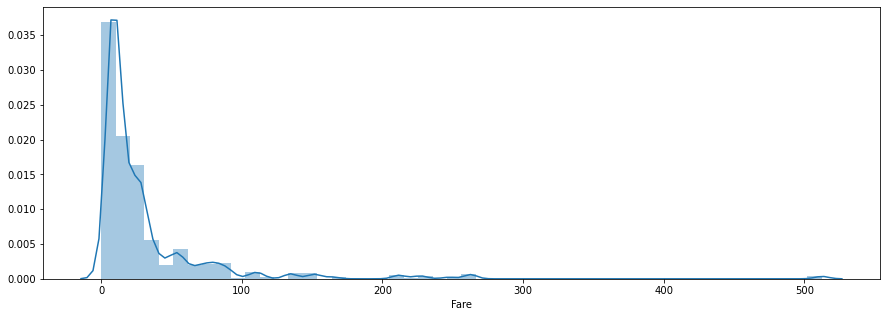

In [28]:
plt.figure(figsize=(15,5))
sns.distplot(a=x_train['Fare'])

In [29]:
# there are 230 unique values out of 712
# since many of them are close in values, we can approximates values into groups
X_train['Fare'] = (x_train['Fare']/10).round()*10

X_valid['Fare'] = x_valid['Fare']
X_test['Fare'] = test['Fare']
X_test['Fare'].fillna(X_test['Fare'].mean(), inplace=True)

## Cabin

In [30]:
x_train['Cabin'].isnull().sum()

552

In [31]:
x_train['Cabin'].value_counts()

G6             3
D              3
E101           3
F2             3
C23 C25 C27    3
              ..
A36            1
D36            1
A16            1
E67            1
E63            1
Name: Cabin, Length: 123, dtype: int64

In [32]:
# there are many missing values and unique values
# we will an engineer feature that indicates if the passenger had a cabin or not
# if given more information about a cabin (ex: location, meaning of number...), a better feature could be engineered

# 0 for no cabin. 1 for cabin
X_train['Cabin']=x_train['Cabin'].notnull().astype('int')
X_valid['Cabin']=x_valid['Cabin'].notnull().astype('int')
X_test['Cabin'] = test['Cabin'].notnull().astype('int')

## Embarked

In [33]:
x_train['Embarked'].value_counts()

S    512
C    138
Q     61
Name: Embarked, dtype: int64

In [34]:
categorical_data_train['Embarked'] = x_train['Embarked']
categorical_data_valid['Embarked'] = x_valid['Embarked']
categorical_data_test['Embarked'] = test['Embarked']

# ENCODING CATEGORICAL VARIABLES

In [35]:
categorical_data_train.head(10)

,Title,Sex,Embarked
364,Mr,male,Q
256,Mrs,female,C
477,Mr,male,S
272,Mrs,female,S
554,Miss,female,S
768,Mr,male,Q
232,Mr,male,S
536,Major,male,S
163,Mr,male,S
659,Mr,male,C


In [36]:
# Since there aren't too many categorical features,none have a lot of unique values and have nominal values
# we will use One-hot encode 
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)

OH_data_train = pd.DataFrame(OH_encoder.fit_transform(categorical_data_train))
OH_data_valid = pd.DataFrame(OH_encoder.transform(categorical_data_valid))
OH_data_test = pd.DataFrame(OH_encoder.transform(categorical_data_test))

OH_data_train.index = categorical_data_train.index
OH_data_valid.index = categorical_data_valid.index
OH_data_test.index = categorical_data_test.index


# we add the one hot encoded categorical data to the numerical data
X_train = pd.concat([X_train,OH_data_train], axis=1)
X_valid = pd.concat([X_valid,OH_data_valid], axis=1)
X_test = pd.concat([X_test,OH_data_test], axis=1)
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,0,1,2,3,...,10,11,12,13,14,15,16,17,18,19
364,3,29.45254,1,0,20.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
256,1,29.45254,0,0,80.0,0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
477,3,29.00000,1,0,10.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
272,2,41.00000,0,1,20.0,0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
554,3,22.00000,0,0,10.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# MACHINE LEARNING

In [37]:
y_valid = pd.DataFrame(y_valid)

In [38]:
def percentage_error(predicted,actual):
    num_correct = 0
    num_total = len(predicted)
    for i in range(num_total):
        if predicted.iloc[i][0] == actual.iloc[i][0]:
            num_correct += 1
    return num_correct/num_total

In [39]:
my_model = XGBRegressor(n_estimators = 1000, learning_rate=0.25)
my_model.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_valid,y_valid)],verbose=False)
predictions_valid = my_model.predict(X_valid).round()
predictions_valid = pd.DataFrame(predictions_valid.astype(int), columns=['Survived'])
error = percentage_error(predictions_valid,y_valid)
print("the percentage error on the valid set is %f" %(error))

the percentage error on the valid set is 0.758427


In [40]:
my_model_2 = RandomForestRegressor(n_estimators=100, random_state = 0)
my_model_2.fit(X_train,y_train)
predictions_valid_2 = my_model_2.predict(X_valid)
predictions_valid_2 = pd.DataFrame(predictions_valid_2.astype(int), columns=['Survived'])
error_2 = percentage_error(predictions_valid_2,y_valid)
print("the percentage error on the valid set is %f" %(error_2))

the percentage error on the valid set is 0.657303


In [41]:
my_model_3 = DecisionTreeRegressor(max_leaf_nodes=150, random_state = 0)
my_model_3.fit(X_train,y_train)
predictions_valid_3 = my_model_3.predict(X_valid)
predictions_valid_3 = pd.DataFrame(predictions_valid_3.astype(int), columns=['Survived'])
error_3 = percentage_error(predictions_valid_3,y_valid)
print("the percentage error on the valid set is %f" %(error_3))

the percentage error on the valid set is 0.741573


In [42]:
# Since my_model performed the best on the valid set, we will use it to make predictions on the test data

# SUBMISSION

In [43]:
predictions_test = my_model.predict(X_test).round()
predictions_test = pd.DataFrame(predictions_test.astype(int), columns=['Survived'])
predictions_test.head(10)

,Survived
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,1
9,0


In [44]:
# we want our submission to look like this 
example = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
example.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [45]:
predictions_test['PassengerId'] = test['PassengerId']
columns_titles = ["PassengerId","Survived"]
predictions_test=predictions_test.reindex(columns=columns_titles)
predictions_test.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [46]:
predictions_test.to_csv('submission.csv',index=False)